# Character-Level LSTM in PyTorch

In this notebook, I'll construct a character-level LSTM with PyTorch. The network will train character by character on some text, then generate new text character by character. As an example, I will train on Anna Karenina. **This model will be able to generate new text based on the text from the book!**

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn). Below is the general architecture of the character-wise RNN.

<img src="assets/charseq.jpeg" width="500">

First let's load in our required resources for data loading and model creation.

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

## Load in Data



In [2]:
# isolating the review column and saving it to a text file
data = pd.read_csv('./data/Airline_Reviews.csv', encoding='utf-8')
data = data['Review']
data.to_csv('./data/reviews.txt', index=False, header=False, sep='\n')

# open text file and read in data as `text`
with open('data/reviews.txt', 'r') as f:
    text = f.read()

### Tokenization

In the cells, below, I'm creating a couple **dictionaries** to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [3]:
# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])

And we can see those same characters from above, encoded as integers.

## Pre-processing the data

As you can see in our char-RNN image above, our LSTM expects an input that is **one-hot encoded** meaning that each character is converted into an integer (via our created dictionary) and *then* converted into a column vector where only it's corresponding integer index will have the value of 1 and the rest of the vector will be filled with 0's. Since we're one-hot encoding the data, let's make a function to do that!


In [4]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

## Making training mini-batches


To train on this data, we also want to create mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. 

In this example, we'll take the encoded characters (passed in as the `arr` parameter) and split them into multiple sequences, given by `batch_size`. Each of our sequences will be `seq_length` long.

### Creating Batches

**1. The first thing we need to do is discard some of the text so we only have completely full mini-batches. **

Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences in a batch) and $M$ is the seq_length or number of time steps in a sequence. Then, to get the total number of batches, $K$, that we can make from the array `arr`, you divide the length of `arr` by the number of characters per batch. Once you know the number of batches, you can get the total number of characters to keep from `arr`, $N * M * K$.

**2. After that, we need to split `arr` into $N$ batches. ** 

You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences in a batch, so let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$.

**3. Now that we have this array, we can iterate through it to get our mini-batches. **

The idea is each batch is a $N \times M$ window on the $N \times (M * K)$ array. For each subsequent batch, the window moves over by `seq_length`. We also want to create both the input and target arrays. Remember that the targets are just the inputs shifted over by one character. The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of tokens in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `seq_length` wide.


In [5]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

### Testing Implementation

Now I'll make some data sets and we can check out what's going on as we batch data. Here, as an example, I'm going to use a batch size of 8 and 50 sequence steps.

The data is shifted over one step for `y`.

---
## Defining the network with PyTorch

### Model Structure

In `__init__` the suggested structure is as follows:
* Create and store the necessary dictionaries (this has been done for you)
* Define an LSTM layer that takes as params: an input size (the number of characters), a hidden layer size `n_hidden`, a number of layers `n_layers`, a dropout probability `drop_prob`, and a batch_first boolean (True, since we are batching)
* Define a dropout layer with `drop_prob`
* Define a fully-connected layer with params: input size `n_hidden` and output size (the number of characters)
* Finally, initialize the weights (again, this has been given)

Note that some parameters have been named and given in the `__init__` function, and we use them and store them by doing something like `self.drop_prob = drop_prob`.

---
### LSTM Inputs/Outputs

You can create a basic [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) as follows

```python
self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
```

where `input_size` is the number of characters this cell expects to see as sequential input, and `n_hidden` is the number of units in the hidden layers in the cell. And we can add dropout by adding a dropout parameter with a specified probability; this will automatically add dropout to the inputs or outputs. Finally, in the `forward` function, we can stack up the LSTM cells into layers using `.view`. With this, you pass in a list of cells and it will send the output of one cell into the next cell.

We also need to create an initial hidden state of all zeros. This is done like so

```python
self.init_hidden()
```

In [6]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [13]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.1, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        self.save_path = "./preTrained/" + str(self.n_layers) + "_" + str(self.n_hidden) + "_" + str(self.drop_prob) + ".net"

        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

## Time to train

The train function gives us the ability to set the number of epochs, the learning rate, and other parameters.

Below we're using an Adam optimizer and cross entropy loss since we are looking at character class scores as output. We calculate the loss and perform backpropagation, as usual!

A couple of details about training: 
>* Within the batch loop, we detach the hidden state from its history; this time setting it equal to a new *tuple* variable because an LSTM has a hidden state that is a tuple of the hidden and cell states.
* We use [`clip_grad_norm_`](https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html) to help prevent exploding gradients.

In [15]:
def plot_loss(train, ax, val):
    iterations = np.arange(len(train))
    ax.set_ylabel("Loss")
    ax.set_title("Learning Curve")
    t_loss = ax.plot(iterations, train, color="black", label = "train loss")
    v_loss = ax.plot(iterations, val, color="red",linestyle='--',label= "val loss")
    ax.legend()

# change the name, for saving multiple files
def save(net):

    checkpoint = {'n_hidden': net.n_hidden,
                'n_layers': net.n_layers,
                'drop_prob': net.drop_prob,
                'state_dict': net.state_dict(),
                'tokens': net.chars}

    with open(net.save_path, 'wb') as f:
        torch.save(checkpoint, f)

# loads the model from a file
def load(name):
    with open(name, 'rb') as f:
        checkpoint = torch.load(f)
        
    loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'], drop_prob = checkpoint['drop_prob']
    )
    loaded.load_state_dict(checkpoint['state_dict'])
    return loaded

def train(net, data, epochs=10, batch_size=128, seq_length=100, lr=0.001, clip=5, val_frac=0.2, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    loss_acc = 0
    n_chars = len(net.chars)
    total_val_losses = []
    total_train_losses = []
    for e in tqdm(range(epochs)):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss_acc += loss.item()
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

                total_val_losses.append(np.mean(val_losses))
                total_train_losses.append(loss_acc / counter)
    fig,axs = plt.subplots(1,1,figsize=(7,5))
    plot_loss(total_train_losses, axs, total_val_losses)
    np.save("./losses/CharRNN_air_reviews_train_" + str(net.n_layers) + "_" + str(net.n_hidden) + ".npy", np.array(total_train_losses))
    np.save("./losses/CharRNN_air_reviews_val_" + str(net.n_layers) + "_" + str(net.n_hidden) + ".npy", np.array(total_val_losses))
    save(net)


In [9]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

In [10]:
def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

## Instantiating the model

Now we can actually train the network. First we'll create the network itself, with some given hyperparameters. Then, define the mini-batches sizes, and start training!

In [14]:
# define and print the net
n_hidden=512
n_layers=2
net = CharRNN(chars, n_hidden, n_layers, drop_prob = 0)
print(net)

CharRNN(
  (lstm): LSTM(474, 512, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=512, out_features=474, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10... Step: 100... Loss: 3.1141... Val Loss: 3.0864
Epoch: 1/10... Step: 200... Loss: 3.0673... Val Loss: 3.0628
Epoch: 1/10... Step: 300... Loss: 2.8159... Val Loss: 2.7921
Epoch: 1/10... Step: 400... Loss: 2.6041... Val Loss: 2.5860
Epoch: 1/10... Step: 500... Loss: 2.4318... Val Loss: 2.4643
Epoch: 1/10... Step: 600... Loss: 2.3305... Val Loss: 2.3172
Epoch: 1/10... Step: 700... Loss: 2.2065... Val Loss: 2.2004
Epoch: 1/10... Step: 800... Loss: 2.1787... Val Loss: 2.1085
Epoch: 1/10... Step: 900... Loss: 2.0395... Val Loss: 2.0627
Epoch: 1/10... Step: 1000... Loss: 1.9839... Val Loss: 1.9690


 10%|█         | 1/10 [08:51<1:19:45, 531.68s/it]

Epoch: 2/10... Step: 1100... Loss: 1.9060... Val Loss: 1.9136
Epoch: 2/10... Step: 1200... Loss: 1.8814... Val Loss: 1.8562
Epoch: 2/10... Step: 1300... Loss: 1.7770... Val Loss: 1.8059
Epoch: 2/10... Step: 1400... Loss: 1.7633... Val Loss: 1.7628
Epoch: 2/10... Step: 1500... Loss: 1.7004... Val Loss: 1.7284
Epoch: 2/10... Step: 1600... Loss: 1.6751... Val Loss: 1.6898
Epoch: 2/10... Step: 1700... Loss: 1.6710... Val Loss: 1.6582
Epoch: 2/10... Step: 1800... Loss: 1.5959... Val Loss: 1.6240
Epoch: 2/10... Step: 1900... Loss: 1.6282... Val Loss: 1.5973
Epoch: 2/10... Step: 2000... Loss: 1.5360... Val Loss: 1.5719


 20%|██        | 2/10 [19:25<1:18:52, 591.57s/it]

Epoch: 3/10... Step: 2100... Loss: 1.5568... Val Loss: 1.5510
Epoch: 3/10... Step: 2200... Loss: 1.5136... Val Loss: 1.5287
Epoch: 3/10... Step: 2300... Loss: 1.5167... Val Loss: 1.5114
Epoch: 3/10... Step: 2400... Loss: 1.4874... Val Loss: 1.4906
Epoch: 3/10... Step: 2500... Loss: 1.5080... Val Loss: 1.4757
Epoch: 3/10... Step: 2600... Loss: 1.4404... Val Loss: 1.4586
Epoch: 3/10... Step: 2700... Loss: 1.4527... Val Loss: 1.4491
Epoch: 3/10... Step: 2800... Loss: 1.4404... Val Loss: 1.4296
Epoch: 3/10... Step: 2900... Loss: 1.4530... Val Loss: 1.4231
Epoch: 3/10... Step: 3000... Loss: 1.3783... Val Loss: 1.4091
Epoch: 3/10... Step: 3100... Loss: 1.4320... Val Loss: 1.4011


 30%|███       | 3/10 [29:02<1:08:15, 585.13s/it]

Epoch: 4/10... Step: 3200... Loss: 1.3445... Val Loss: 1.3899
Epoch: 4/10... Step: 3300... Loss: 1.3927... Val Loss: 1.3827
Epoch: 4/10... Step: 3400... Loss: 1.3468... Val Loss: 1.3696
Epoch: 4/10... Step: 3500... Loss: 1.3380... Val Loss: 1.3637
Epoch: 4/10... Step: 3600... Loss: 1.3561... Val Loss: 1.3547
Epoch: 4/10... Step: 3700... Loss: 1.3193... Val Loss: 1.3459
Epoch: 4/10... Step: 3800... Loss: 1.3824... Val Loss: 1.3411
Epoch: 4/10... Step: 3900... Loss: 1.3190... Val Loss: 1.3335
Epoch: 4/10... Step: 4000... Loss: 1.2991... Val Loss: 1.3287
Epoch: 4/10... Step: 4100... Loss: 1.2837... Val Loss: 1.3216


 40%|████      | 4/10 [38:19<57:22, 573.79s/it]  

Epoch: 5/10... Step: 4200... Loss: 1.3137... Val Loss: 1.3201
Epoch: 5/10... Step: 4300... Loss: 1.3288... Val Loss: 1.3108
Epoch: 5/10... Step: 4400... Loss: 1.2852... Val Loss: 1.3041
Epoch: 5/10... Step: 4500... Loss: 1.2737... Val Loss: 1.3031
Epoch: 5/10... Step: 4600... Loss: 1.2646... Val Loss: 1.2955
Epoch: 5/10... Step: 4700... Loss: 1.2730... Val Loss: 1.2923
Epoch: 5/10... Step: 4800... Loss: 1.2940... Val Loss: 1.2867
Epoch: 5/10... Step: 4900... Loss: 1.2584... Val Loss: 1.2814
Epoch: 5/10... Step: 5000... Loss: 1.2617... Val Loss: 1.2820
Epoch: 5/10... Step: 5100... Loss: 1.2355... Val Loss: 1.2770
Epoch: 5/10... Step: 5200... Loss: 1.2803... Val Loss: 1.2701


 50%|█████     | 5/10 [47:56<47:55, 575.15s/it]

Epoch: 6/10... Step: 5300... Loss: 1.2241... Val Loss: 1.2651
Epoch: 6/10... Step: 5400... Loss: 1.2288... Val Loss: 1.2650
Epoch: 6/10... Step: 5500... Loss: 1.2341... Val Loss: 1.2618
Epoch: 6/10... Step: 5600... Loss: 1.2191... Val Loss: 1.2593
Epoch: 6/10... Step: 5700... Loss: 1.2472... Val Loss: 1.2528
Epoch: 6/10... Step: 5800... Loss: 1.2401... Val Loss: 1.2494
Epoch: 6/10... Step: 5900... Loss: 1.2385... Val Loss: 1.2491
Epoch: 6/10... Step: 6000... Loss: 1.2116... Val Loss: 1.2417
Epoch: 6/10... Step: 6100... Loss: 1.1823... Val Loss: 1.2393
Epoch: 6/10... Step: 6200... Loss: 1.2034... Val Loss: 1.2398


 60%|██████    | 6/10 [57:05<37:45, 566.30s/it]

Epoch: 7/10... Step: 6300... Loss: 1.2284... Val Loss: 1.2419
Epoch: 7/10... Step: 6400... Loss: 1.2505... Val Loss: 1.2455
Epoch: 7/10... Step: 6500... Loss: 1.1809... Val Loss: 1.2360
Epoch: 7/10... Step: 6600... Loss: 1.2086... Val Loss: 1.2322
Epoch: 7/10... Step: 6700... Loss: 1.2324... Val Loss: 1.2322
Epoch: 7/10... Step: 6800... Loss: 1.2283... Val Loss: 1.2261
Epoch: 7/10... Step: 6900... Loss: 1.1976... Val Loss: 1.2249
Epoch: 7/10... Step: 7000... Loss: 1.2137... Val Loss: 1.2234
Epoch: 7/10... Step: 7100... Loss: 1.1606... Val Loss: 1.2211
Epoch: 7/10... Step: 7200... Loss: 1.1678... Val Loss: 1.2194
Epoch: 7/10... Step: 7300... Loss: 1.1820... Val Loss: 1.2154


 70%|███████   | 7/10 [1:06:42<28:29, 569.85s/it]

Epoch: 8/10... Step: 7400... Loss: 1.1744... Val Loss: 1.2105
Epoch: 8/10... Step: 7500... Loss: 1.1631... Val Loss: 1.2081
Epoch: 8/10... Step: 7600... Loss: 1.1712... Val Loss: 1.2071
Epoch: 8/10... Step: 7700... Loss: 1.1790... Val Loss: 1.2058
Epoch: 8/10... Step: 7800... Loss: 1.1359... Val Loss: 1.2140
Epoch: 8/10... Step: 7900... Loss: 1.1952... Val Loss: 1.2038
Epoch: 8/10... Step: 8000... Loss: 1.1764... Val Loss: 1.2049
Epoch: 8/10... Step: 8100... Loss: 1.1948... Val Loss: 1.1977
Epoch: 8/10... Step: 8200... Loss: 1.1808... Val Loss: 1.2005
Epoch: 8/10... Step: 8300... Loss: 1.1796... Val Loss: 1.1941


 80%|████████  | 8/10 [1:15:51<18:46, 563.24s/it]

Epoch: 9/10... Step: 8400... Loss: 1.1660... Val Loss: 1.2139
Epoch: 9/10... Step: 8500... Loss: 1.1690... Val Loss: 1.1970
Epoch: 9/10... Step: 8600... Loss: 1.1885... Val Loss: 1.1933
Epoch: 9/10... Step: 8700... Loss: 1.1714... Val Loss: 1.1919
Epoch: 9/10... Step: 8800... Loss: 1.1688... Val Loss: 1.1890
Epoch: 9/10... Step: 8900... Loss: 1.1367... Val Loss: 1.1914
Epoch: 9/10... Step: 9000... Loss: 1.1087... Val Loss: 1.1867
Epoch: 9/10... Step: 9100... Loss: 1.1577... Val Loss: 1.1888
Epoch: 9/10... Step: 9200... Loss: 1.1496... Val Loss: 1.1832
Epoch: 9/10... Step: 9300... Loss: 1.1948... Val Loss: 1.1833
Epoch: 9/10... Step: 9400... Loss: 1.1459... Val Loss: 1.1835


 90%|█████████ | 9/10 [1:25:28<09:27, 567.39s/it]

Epoch: 10/10... Step: 9500... Loss: 1.1539... Val Loss: 1.1774
Epoch: 10/10... Step: 9600... Loss: 1.1541... Val Loss: 1.1784
Epoch: 10/10... Step: 9700... Loss: 1.1678... Val Loss: 1.1793
Epoch: 10/10... Step: 9800... Loss: 1.1691... Val Loss: 1.1740
Epoch: 10/10... Step: 9900... Loss: 1.1154... Val Loss: 1.1764
Epoch: 10/10... Step: 10000... Loss: 1.1690... Val Loss: 1.1726
Epoch: 10/10... Step: 10100... Loss: 1.1309... Val Loss: 1.1753
Epoch: 10/10... Step: 10200... Loss: 1.1177... Val Loss: 1.1703
Epoch: 10/10... Step: 10300... Loss: 1.1454... Val Loss: 1.1707
Epoch: 10/10... Step: 10400... Loss: 1.1952... Val Loss: 1.1686


100%|██████████| 10/10 [1:34:37<00:00, 567.72s/it]


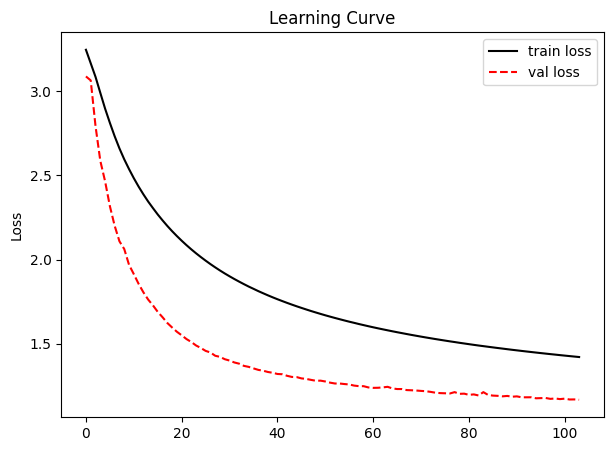

In [15]:
# train the model
train(net, encoded, lr=0.001, print_every=100)

We might observe that the training error is higher than the validation error, presumably because of the use of dropout.

### Priming and generating text 

Typically you'll want to prime the network so you can build up a hidden state. Otherwise the network will start out generating characters at random. In general the first bunch of characters will be a little rough since it hasn't built up a long history of characters to predict from.

In [19]:
print(sample(net, 1000, prime='The flight', top_k=5))

The flight was delayed. I was a little either. All in a seat was served on the first flight attendants which was overboard, and I conslice was ok. We flew with Canada to Beijing, treat the flight on the same airlines asked for two flights which was one of the trip from Baggage to Mumbai to Man with an airport they were taking the phone to tell you the same airline. I was on a regional flight attendant were then too small. Then the staff were then check-on which I would be during already announcement to me and the food. They said I was told any cheap shors.
  This was ok, always also the passengers will be able to get our change the checking on the service onboard condition in the same flight."
"  This was okay and they didn't already free well.
 Friends arrival at all. I am a lot of the airline would not access. The seats were telling me. I would never happen for a bit my his and to the plannes and stewer they are suppond out of anyone.
  After that was a bus to the touch with them aga

#### Word construction looks okay but sentences not at all.

Since validation was still decreasing, let's reload the model and train it for another 10 epochs. Let's see if the generation improves.

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10... Step: 100... Loss: 1.1339... Val Loss: 1.1610
Epoch: 1/10... Step: 200... Loss: 1.1144... Val Loss: 1.1645
Epoch: 1/10... Step: 300... Loss: 1.1276... Val Loss: 1.1650
Epoch: 1/10... Step: 400... Loss: 1.1367... Val Loss: 1.1629
Epoch: 1/10... Step: 500... Loss: 1.1243... Val Loss: 1.1608
Epoch: 1/10... Step: 600... Loss: 1.1073... Val Loss: 1.1675
Epoch: 1/10... Step: 700... Loss: 1.1332... Val Loss: 1.1583
Epoch: 1/10... Step: 800... Loss: 1.2048... Val Loss: 1.1563
Epoch: 1/10... Step: 900... Loss: 1.1102... Val Loss: 1.1590
Epoch: 1/10... Step: 1000... Loss: 1.0969... Val Loss: 1.1563


 10%|█         | 1/10 [09:07<1:22:08, 547.58s/it]

Epoch: 2/10... Step: 1100... Loss: 1.1279... Val Loss: 1.1929
Epoch: 2/10... Step: 1200... Loss: 1.1113... Val Loss: 1.1815
Epoch: 2/10... Step: 1300... Loss: 1.0822... Val Loss: 1.1573
Epoch: 2/10... Step: 1400... Loss: 1.1123... Val Loss: 1.1590
Epoch: 2/10... Step: 1500... Loss: 1.1181... Val Loss: 1.1624
Epoch: 2/10... Step: 1600... Loss: 1.1018... Val Loss: 1.1559
Epoch: 2/10... Step: 1700... Loss: 1.1401... Val Loss: 1.1523
Epoch: 2/10... Step: 1800... Loss: 1.1034... Val Loss: 1.1511
Epoch: 2/10... Step: 1900... Loss: 1.1484... Val Loss: 1.1501
Epoch: 2/10... Step: 2000... Loss: 1.0769... Val Loss: 1.1531


 20%|██        | 2/10 [18:14<1:12:57, 547.24s/it]

Epoch: 3/10... Step: 2100... Loss: 1.1577... Val Loss: 1.2013
Epoch: 3/10... Step: 2200... Loss: 1.1018... Val Loss: 1.1734
Epoch: 3/10... Step: 2300... Loss: 1.1337... Val Loss: 1.1897
Epoch: 3/10... Step: 2400... Loss: 1.1123... Val Loss: 1.1864
Epoch: 3/10... Step: 2500... Loss: 1.1404... Val Loss: 1.1781
Epoch: 3/10... Step: 2600... Loss: 1.0943... Val Loss: 1.1796
Epoch: 3/10... Step: 2700... Loss: 1.1132... Val Loss: 1.1801
Epoch: 3/10... Step: 2800... Loss: 1.1298... Val Loss: 1.1810
Epoch: 3/10... Step: 2900... Loss: 1.1492... Val Loss: 1.1841
Epoch: 3/10... Step: 3000... Loss: 1.0810... Val Loss: 1.1763
Epoch: 3/10... Step: 3100... Loss: 1.1490... Val Loss: 1.1824


 30%|███       | 3/10 [27:48<1:05:17, 559.62s/it]

Epoch: 4/10... Step: 3200... Loss: 1.0932... Val Loss: 1.2962
Epoch: 4/10... Step: 3300... Loss: 1.1337... Val Loss: 1.2660
Epoch: 4/10... Step: 3400... Loss: 1.0906... Val Loss: 1.1566
Epoch: 4/10... Step: 3500... Loss: 1.0865... Val Loss: 1.1544
Epoch: 4/10... Step: 3600... Loss: 1.1154... Val Loss: 1.1592
Epoch: 4/10... Step: 3700... Loss: 1.0864... Val Loss: 1.1585
Epoch: 4/10... Step: 3800... Loss: 1.1383... Val Loss: 1.1518
Epoch: 4/10... Step: 3900... Loss: 1.0982... Val Loss: 1.1576
Epoch: 4/10... Step: 4000... Loss: 1.0736... Val Loss: 1.1531
Epoch: 4/10... Step: 4100... Loss: 1.0673... Val Loss: 1.1508


 40%|████      | 4/10 [36:55<55:26, 554.49s/it]  

Epoch: 5/10... Step: 4200... Loss: 1.1073... Val Loss: 1.2345
Epoch: 5/10... Step: 4300... Loss: 1.1190... Val Loss: 1.1375
Epoch: 5/10... Step: 4400... Loss: 1.0963... Val Loss: 1.1464
Epoch: 5/10... Step: 4500... Loss: 1.0879... Val Loss: 1.1409
Epoch: 5/10... Step: 4600... Loss: 1.0810... Val Loss: 1.1370
Epoch: 5/10... Step: 4700... Loss: 1.1031... Val Loss: 1.1401
Epoch: 5/10... Step: 4800... Loss: 1.1065... Val Loss: 1.1342
Epoch: 5/10... Step: 4900... Loss: 1.0824... Val Loss: 1.1380
Epoch: 5/10... Step: 5000... Loss: 1.0785... Val Loss: 1.1397
Epoch: 5/10... Step: 5100... Loss: 1.0686... Val Loss: 1.1340
Epoch: 5/10... Step: 5200... Loss: 1.1007... Val Loss: 1.1336


 50%|█████     | 5/10 [46:32<46:52, 562.54s/it]

Epoch: 6/10... Step: 5300... Loss: 1.0654... Val Loss: 1.1243
Epoch: 6/10... Step: 5400... Loss: 1.0675... Val Loss: 1.1260
Epoch: 6/10... Step: 5500... Loss: 1.0856... Val Loss: 1.1234
Epoch: 6/10... Step: 5600... Loss: 1.0533... Val Loss: 1.1226
Epoch: 6/10... Step: 5700... Loss: 1.0974... Val Loss: 1.1254
Epoch: 6/10... Step: 5800... Loss: 1.0969... Val Loss: 1.1257
Epoch: 6/10... Step: 5900... Loss: 1.0936... Val Loss: 1.1257
Epoch: 6/10... Step: 6000... Loss: 1.0737... Val Loss: 1.1231
Epoch: 6/10... Step: 6100... Loss: 1.0502... Val Loss: 1.1221
Epoch: 6/10... Step: 6200... Loss: 1.0731... Val Loss: 1.1235


 60%|██████    | 6/10 [55:41<37:11, 557.85s/it]

Epoch: 7/10... Step: 6300... Loss: 1.1229... Val Loss: 1.1967
Epoch: 7/10... Step: 6400... Loss: 1.1121... Val Loss: 1.1164
Epoch: 7/10... Step: 6500... Loss: 1.0615... Val Loss: 1.1146
Epoch: 7/10... Step: 6600... Loss: 1.0759... Val Loss: 1.1159
Epoch: 7/10... Step: 6700... Loss: 1.0794... Val Loss: 1.1180
Epoch: 7/10... Step: 6800... Loss: 1.0984... Val Loss: 1.1173
Epoch: 7/10... Step: 6900... Loss: 1.0661... Val Loss: 1.1168
Epoch: 7/10... Step: 7000... Loss: 1.0897... Val Loss: 1.1155
Epoch: 7/10... Step: 7100... Loss: 1.0467... Val Loss: 1.1167
Epoch: 7/10... Step: 7200... Loss: 1.0585... Val Loss: 1.1172
Epoch: 7/10... Step: 7300... Loss: 1.0707... Val Loss: 1.1173


 70%|███████   | 7/10 [1:05:16<28:10, 563.58s/it]

Epoch: 8/10... Step: 7400... Loss: 1.0591... Val Loss: 1.1211
Epoch: 8/10... Step: 7500... Loss: 1.0549... Val Loss: 1.1209
Epoch: 8/10... Step: 7600... Loss: 1.0612... Val Loss: 1.1104
Epoch: 8/10... Step: 7700... Loss: 1.0617... Val Loss: 1.1091
Epoch: 8/10... Step: 7800... Loss: 1.0255... Val Loss: 1.1163
Epoch: 8/10... Step: 7900... Loss: 1.0751... Val Loss: 1.1151
Epoch: 8/10... Step: 8000... Loss: 1.0703... Val Loss: 1.1121
Epoch: 8/10... Step: 8100... Loss: 1.0858... Val Loss: 1.1132
Epoch: 8/10... Step: 8200... Loss: 1.0706... Val Loss: 1.1121
Epoch: 8/10... Step: 8300... Loss: 1.0700... Val Loss: 1.1086


 80%|████████  | 8/10 [1:14:28<18:39, 559.78s/it]

Epoch: 9/10... Step: 8400... Loss: 1.0615... Val Loss: 1.1365
Epoch: 9/10... Step: 8500... Loss: 1.0656... Val Loss: 1.1446
Epoch: 9/10... Step: 8600... Loss: 1.0871... Val Loss: 1.1126
Epoch: 9/10... Step: 8700... Loss: 1.0733... Val Loss: 1.1144
Epoch: 9/10... Step: 8800... Loss: 1.0604... Val Loss: 1.1108
Epoch: 9/10... Step: 8900... Loss: 1.0482... Val Loss: 1.1140
Epoch: 9/10... Step: 9000... Loss: 1.0139... Val Loss: 1.1069
Epoch: 9/10... Step: 9100... Loss: 1.0584... Val Loss: 1.1103
Epoch: 9/10... Step: 9200... Loss: 1.0583... Val Loss: 1.1070
Epoch: 9/10... Step: 9300... Loss: 1.0997... Val Loss: 1.1134
Epoch: 9/10... Step: 9400... Loss: 1.0588... Val Loss: 1.1079


 90%|█████████ | 9/10 [1:24:14<09:28, 568.01s/it]

Epoch: 10/10... Step: 9500... Loss: 1.0630... Val Loss: 1.1179
Epoch: 10/10... Step: 9600... Loss: 1.0574... Val Loss: 1.1077
Epoch: 10/10... Step: 9700... Loss: 1.0753... Val Loss: 1.1090
Epoch: 10/10... Step: 9800... Loss: 1.0765... Val Loss: 1.1107
Epoch: 10/10... Step: 9900... Loss: 1.0250... Val Loss: 1.1115
Epoch: 10/10... Step: 10000... Loss: 1.0803... Val Loss: 1.1081
Epoch: 10/10... Step: 10100... Loss: 1.0471... Val Loss: 1.1131
Epoch: 10/10... Step: 10200... Loss: 1.0301... Val Loss: 1.1064
Epoch: 10/10... Step: 10300... Loss: 1.0515... Val Loss: 1.1106
Epoch: 10/10... Step: 10400... Loss: 1.1035... Val Loss: 1.1010


100%|██████████| 10/10 [1:33:30<00:00, 561.02s/it]


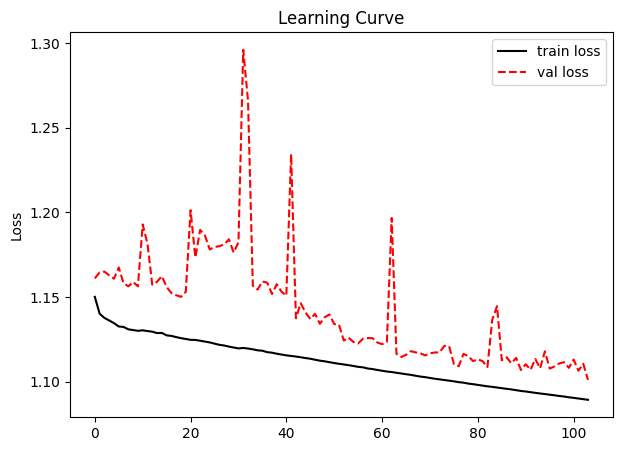

In [21]:
train(loaded, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=100)

In [22]:
# Sample using a loaded model
print(sample(loaded, 2000, top_k=5, prime="The flight"))

The flight would be my bags for our suitcade and they told me two and a seat which will be the medication.
  I will never fly Air Namibia with an emerged one way.
"
"  Bristow to Tokyo and one way. I have everything above this to the first time we were asked to take you flying to a lot of the flight to Bangkok and the plane was almost the staff to the time I went to the flight to Manila. Then to the front decided to top it at me with a ticket for the aircraft to the plane. They don't expect the flight without and seess to be a case. The first flight was on other flight we didn't canceled my trip from Lufthansa. They still have to see is the worst.
  I had a supervisor friendly booking a single times. I am always facilities to the airport we were stort to finish wheels in the aisle and ours which we can defore we were taken out of the time of they could hell taste on the flight with the front to me, at the carousel. The flight was cancelled. The attendant would have to pay the flight. T

#### Not much of an improvement

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15... Step: 100... Loss: 3.1138... Val Loss: 3.0865
Epoch: 1/15... Step: 200... Loss: 2.7124... Val Loss: 2.7114
Epoch: 1/15... Step: 300... Loss: 2.4416... Val Loss: 2.4269
Epoch: 1/15... Step: 400... Loss: 2.1882... Val Loss: 2.1852
Epoch: 1/15... Step: 500... Loss: 1.9891... Val Loss: 1.9897
Epoch: 1/15... Step: 600... Loss: 1.8313... Val Loss: 1.8249
Epoch: 1/15... Step: 700... Loss: 1.6944... Val Loss: 1.6949
Epoch: 1/15... Step: 800... Loss: 1.6687... Val Loss: 1.5881
Epoch: 1/15... Step: 900... Loss: 1.4972... Val Loss: 1.5167
Epoch: 1/15... Step: 1000... Loss: 1.4144... Val Loss: 1.4480


  7%|▋         | 1/15 [21:54<5:06:39, 1314.25s/it]

Epoch: 2/15... Step: 1100... Loss: 1.3726... Val Loss: 1.4024
Epoch: 2/15... Step: 1200... Loss: 1.3566... Val Loss: 1.3654
Epoch: 2/15... Step: 1300... Loss: 1.2792... Val Loss: 1.3316
Epoch: 2/15... Step: 1400... Loss: 1.2913... Val Loss: 1.3120
Epoch: 2/15... Step: 1500... Loss: 1.2574... Val Loss: 1.2855
Epoch: 2/15... Step: 1600... Loss: 1.2248... Val Loss: 1.2676
Epoch: 2/15... Step: 1700... Loss: 1.2502... Val Loss: 1.2527
Epoch: 2/15... Step: 1800... Loss: 1.1972... Val Loss: 1.2365
Epoch: 2/15... Step: 1900... Loss: 1.2298... Val Loss: 1.2221
Epoch: 2/15... Step: 2000... Loss: 1.1446... Val Loss: 1.2135


 13%|█▎        | 2/15 [43:44<4:44:17, 1312.11s/it]

Epoch: 3/15... Step: 2100... Loss: 1.1884... Val Loss: 1.2035
Epoch: 3/15... Step: 2200... Loss: 1.1538... Val Loss: 1.1912
Epoch: 3/15... Step: 2300... Loss: 1.1755... Val Loss: 1.1817
Epoch: 3/15... Step: 2400... Loss: 1.1530... Val Loss: 1.1781
Epoch: 3/15... Step: 2500... Loss: 1.1734... Val Loss: 1.1682
Epoch: 3/15... Step: 2600... Loss: 1.1145... Val Loss: 1.1598
Epoch: 3/15... Step: 2700... Loss: 1.1298... Val Loss: 1.1556
Epoch: 3/15... Step: 2800... Loss: 1.1380... Val Loss: 1.1441
Epoch: 3/15... Step: 2900... Loss: 1.1498... Val Loss: 1.1423
Epoch: 3/15... Step: 3000... Loss: 1.0824... Val Loss: 1.1359
Epoch: 3/15... Step: 3100... Loss: 1.1479... Val Loss: 1.1309


 20%|██        | 3/15 [1:06:31<4:27:26, 1337.23s/it]

Epoch: 4/15... Step: 3200... Loss: 1.0577... Val Loss: 1.1236
Epoch: 4/15... Step: 3300... Loss: 1.1165... Val Loss: 1.1198
Epoch: 4/15... Step: 3400... Loss: 1.0687... Val Loss: 1.1149
Epoch: 4/15... Step: 3500... Loss: 1.0689... Val Loss: 1.1116
Epoch: 4/15... Step: 3600... Loss: 1.0737... Val Loss: 1.1097
Epoch: 4/15... Step: 3700... Loss: 1.0506... Val Loss: 1.1028
Epoch: 4/15... Step: 3800... Loss: 1.1050... Val Loss: 1.1005
Epoch: 4/15... Step: 3900... Loss: 1.0533... Val Loss: 1.0951
Epoch: 4/15... Step: 4000... Loss: 1.0311... Val Loss: 1.0916
Epoch: 4/15... Step: 4100... Loss: 1.0170... Val Loss: 1.0894


 27%|██▋       | 4/15 [1:28:17<4:02:53, 1324.86s/it]

Epoch: 5/15... Step: 4200... Loss: 1.0326... Val Loss: 1.0877
Epoch: 5/15... Step: 4300... Loss: 1.0599... Val Loss: 1.0772
Epoch: 5/15... Step: 4400... Loss: 1.0399... Val Loss: 1.0750
Epoch: 5/15... Step: 4500... Loss: 1.0277... Val Loss: 1.0792
Epoch: 5/15... Step: 4600... Loss: 1.0131... Val Loss: 1.0725
Epoch: 5/15... Step: 4700... Loss: 1.0368... Val Loss: 1.0690
Epoch: 5/15... Step: 4800... Loss: 1.0337... Val Loss: 1.0702
Epoch: 5/15... Step: 4900... Loss: 1.0123... Val Loss: 1.0633
Epoch: 5/15... Step: 5000... Loss: 1.0132... Val Loss: 1.0599
Epoch: 5/15... Step: 5100... Loss: 0.9859... Val Loss: 1.0554
Epoch: 5/15... Step: 5200... Loss: 1.0166... Val Loss: 1.0551


 33%|███▎      | 5/15 [1:50:55<3:42:46, 1336.64s/it]

Epoch: 6/15... Step: 5300... Loss: 0.9814... Val Loss: 1.0496
Epoch: 6/15... Step: 5400... Loss: 0.9914... Val Loss: 1.0474
Epoch: 6/15... Step: 5500... Loss: 1.0183... Val Loss: 1.0472
Epoch: 6/15... Step: 5600... Loss: 0.9674... Val Loss: 1.0429
Epoch: 6/15... Step: 5700... Loss: 0.9983... Val Loss: 1.0437
Epoch: 6/15... Step: 5800... Loss: 0.9974... Val Loss: 1.0443
Epoch: 6/15... Step: 5900... Loss: 1.0013... Val Loss: 1.0372
Epoch: 6/15... Step: 6000... Loss: 0.9792... Val Loss: 1.0355
Epoch: 6/15... Step: 6100... Loss: 0.9594... Val Loss: 1.0334
Epoch: 6/15... Step: 6200... Loss: 0.9795... Val Loss: 1.0328


 40%|████      | 6/15 [2:12:36<3:18:41, 1324.65s/it]

Epoch: 7/15... Step: 6300... Loss: 0.9955... Val Loss: 1.0338
Epoch: 7/15... Step: 6400... Loss: 0.9991... Val Loss: 1.0295
Epoch: 7/15... Step: 6500... Loss: 0.9640... Val Loss: 1.0244
Epoch: 7/15... Step: 6600... Loss: 0.9601... Val Loss: 1.0256
Epoch: 7/15... Step: 6700... Loss: 0.9761... Val Loss: 1.0293
Epoch: 7/15... Step: 6800... Loss: 0.9854... Val Loss: 1.0233
Epoch: 7/15... Step: 6900... Loss: 0.9575... Val Loss: 1.0209
Epoch: 7/15... Step: 7000... Loss: 0.9794... Val Loss: 1.0164
Epoch: 7/15... Step: 7100... Loss: 0.9250... Val Loss: 1.0181
Epoch: 7/15... Step: 7200... Loss: 0.9333... Val Loss: 1.0158
Epoch: 7/15... Step: 7300... Loss: 0.9406... Val Loss: 1.0154


 47%|████▋     | 7/15 [2:35:25<2:58:33, 1339.22s/it]

Epoch: 8/15... Step: 7400... Loss: 0.9495... Val Loss: 1.0133
Epoch: 8/15... Step: 7500... Loss: 0.9409... Val Loss: 1.0118
Epoch: 8/15... Step: 7600... Loss: 0.9410... Val Loss: 1.0145
Epoch: 8/15... Step: 7700... Loss: 0.9310... Val Loss: 1.0097
Epoch: 8/15... Step: 7800... Loss: 0.9006... Val Loss: 1.0096
Epoch: 8/15... Step: 7900... Loss: 0.9504... Val Loss: 1.0099
Epoch: 8/15... Step: 8000... Loss: 0.9393... Val Loss: 1.0088
Epoch: 8/15... Step: 8100... Loss: 0.9518... Val Loss: 1.0091
Epoch: 8/15... Step: 8200... Loss: 0.9214... Val Loss: 1.0064
Epoch: 8/15... Step: 8300... Loss: 0.9358... Val Loss: 1.0060


 53%|█████▎    | 8/15 [2:57:18<2:35:14, 1330.59s/it]

Epoch: 9/15... Step: 8400... Loss: 0.9252... Val Loss: 1.0112
Epoch: 9/15... Step: 8500... Loss: 0.9319... Val Loss: 1.0044
Epoch: 9/15... Step: 8600... Loss: 0.9477... Val Loss: 1.0043
Epoch: 9/15... Step: 8700... Loss: 0.9401... Val Loss: 1.0013
Epoch: 9/15... Step: 8800... Loss: 0.9152... Val Loss: 1.0051
Epoch: 9/15... Step: 8900... Loss: 0.9062... Val Loss: 1.0031
Epoch: 9/15... Step: 9000... Loss: 0.8714... Val Loss: 1.0019
Epoch: 9/15... Step: 9100... Loss: 0.9126... Val Loss: 1.0047
Epoch: 9/15... Step: 9200... Loss: 0.9218... Val Loss: 1.0047
Epoch: 9/15... Step: 9300... Loss: 0.9447... Val Loss: 0.9974
Epoch: 9/15... Step: 9400... Loss: 0.9104... Val Loss: 0.9988


 60%|██████    | 9/15 [3:20:06<2:14:13, 1342.31s/it]

Epoch: 10/15... Step: 9500... Loss: 0.9115... Val Loss: 1.0019
Epoch: 10/15... Step: 9600... Loss: 0.9091... Val Loss: 0.9996
Epoch: 10/15... Step: 9700... Loss: 0.9261... Val Loss: 0.9967
Epoch: 10/15... Step: 9800... Loss: 0.9092... Val Loss: 1.0000
Epoch: 10/15... Step: 9900... Loss: 0.8724... Val Loss: 0.9978
Epoch: 10/15... Step: 10000... Loss: 0.9094... Val Loss: 0.9994
Epoch: 10/15... Step: 10100... Loss: 0.8998... Val Loss: 1.0031
Epoch: 10/15... Step: 10200... Loss: 0.8798... Val Loss: 0.9964
Epoch: 10/15... Step: 10300... Loss: 0.8866... Val Loss: 0.9983
Epoch: 10/15... Step: 10400... Loss: 0.9487... Val Loss: 1.0015


 67%|██████▋   | 10/15 [3:41:48<1:50:49, 1329.84s/it]

Epoch: 11/15... Step: 10500... Loss: 0.9018... Val Loss: 1.0064
Epoch: 11/15... Step: 10600... Loss: 0.8641... Val Loss: 0.9981
Epoch: 11/15... Step: 10700... Loss: 0.8745... Val Loss: 0.9993
Epoch: 11/15... Step: 10800... Loss: 0.8730... Val Loss: 0.9983
Epoch: 11/15... Step: 10900... Loss: 0.8807... Val Loss: 0.9987
Epoch: 11/15... Step: 11000... Loss: 0.8783... Val Loss: 0.9991
Epoch: 11/15... Step: 11100... Loss: 0.9000... Val Loss: 0.9989
Epoch: 11/15... Step: 11200... Loss: 0.8743... Val Loss: 0.9988
Epoch: 11/15... Step: 11300... Loss: 0.8977... Val Loss: 0.9989
Epoch: 11/15... Step: 11400... Loss: 0.8824... Val Loss: 0.9975
Epoch: 11/15... Step: 11500... Loss: 0.9109... Val Loss: 0.9967


 73%|███████▎  | 11/15 [4:04:13<1:28:57, 1334.48s/it]

Epoch: 12/15... Step: 11600... Loss: 0.8924... Val Loss: 1.2450
Epoch: 12/15... Step: 11700... Loss: 0.9198... Val Loss: 1.2473
Epoch: 12/15... Step: 11800... Loss: 0.8960... Val Loss: 1.2370
Epoch: 12/15... Step: 11900... Loss: 0.8865... Val Loss: 1.2406
Epoch: 12/15... Step: 12000... Loss: 0.8486... Val Loss: 1.2440
Epoch: 12/15... Step: 12100... Loss: 0.8698... Val Loss: 1.2513
Epoch: 12/15... Step: 12200... Loss: 0.8792... Val Loss: 1.2477
Epoch: 12/15... Step: 12300... Loss: 0.8757... Val Loss: 1.2579
Epoch: 12/15... Step: 12400... Loss: 0.8687... Val Loss: 1.2637
Epoch: 12/15... Step: 12500... Loss: 0.8950... Val Loss: 1.2527


 80%|████████  | 12/15 [4:28:08<1:08:15, 1365.08s/it]

Epoch: 13/15... Step: 12600... Loss: 0.8744... Val Loss: 1.0128
Epoch: 13/15... Step: 12700... Loss: 0.8767... Val Loss: 0.9994
Epoch: 13/15... Step: 12800... Loss: 0.8650... Val Loss: 1.0048
Epoch: 13/15... Step: 12900... Loss: 0.8726... Val Loss: 1.0006
Epoch: 13/15... Step: 13000... Loss: 0.8873... Val Loss: 0.9998
Epoch: 13/15... Step: 13100... Loss: 0.8661... Val Loss: 1.0055
Epoch: 13/15... Step: 13200... Loss: 0.9020... Val Loss: 1.0047
Epoch: 13/15... Step: 13300... Loss: 0.8428... Val Loss: 1.0043
Epoch: 13/15... Step: 13400... Loss: 0.8597... Val Loss: 1.0030
Epoch: 13/15... Step: 13500... Loss: 0.8805... Val Loss: 1.0043
Epoch: 13/15... Step: 13600... Loss: 0.8855... Val Loss: 1.0008


 87%|████████▋ | 13/15 [4:51:46<46:02, 1381.27s/it]  

Epoch: 14/15... Step: 13700... Loss: 0.8606... Val Loss: 1.0060
Epoch: 14/15... Step: 13800... Loss: 0.8543... Val Loss: 1.0026
Epoch: 14/15... Step: 13900... Loss: 0.8542... Val Loss: 0.9999
Epoch: 14/15... Step: 14000... Loss: 0.8696... Val Loss: 1.0039
Epoch: 14/15... Step: 14100... Loss: 0.8417... Val Loss: 1.0097
Epoch: 14/15... Step: 14200... Loss: 0.8251... Val Loss: 1.0062
Epoch: 14/15... Step: 14300... Loss: 0.8570... Val Loss: 1.0063
Epoch: 14/15... Step: 14400... Loss: 0.8482... Val Loss: 1.0065
Epoch: 14/15... Step: 14500... Loss: 0.8551... Val Loss: 1.0108
Epoch: 14/15... Step: 14600... Loss: 0.8543... Val Loss: 1.0030


 93%|█████████▎| 14/15 [5:13:18<22:34, 1354.17s/it]

Epoch: 15/15... Step: 14700... Loss: 0.8241... Val Loss: 1.0138
Epoch: 15/15... Step: 14800... Loss: 0.8322... Val Loss: 1.0028
Epoch: 15/15... Step: 14900... Loss: 0.8488... Val Loss: 1.0078
Epoch: 15/15... Step: 15000... Loss: 0.8140... Val Loss: 1.0104
Epoch: 15/15... Step: 15100... Loss: 0.8309... Val Loss: 1.0098
Epoch: 15/15... Step: 15200... Loss: 0.8209... Val Loss: 1.0086
Epoch: 15/15... Step: 15300... Loss: 0.8490... Val Loss: 1.0123
Epoch: 15/15... Step: 15400... Loss: 0.8255... Val Loss: 1.0086
Epoch: 15/15... Step: 15500... Loss: 0.8282... Val Loss: 1.0065
Epoch: 15/15... Step: 15600... Loss: 0.8142... Val Loss: 1.0153
Epoch: 15/15... Step: 15700... Loss: 0.8067... Val Loss: 1.0082


100%|██████████| 15/15 [5:36:01<00:00, 1344.11s/it]


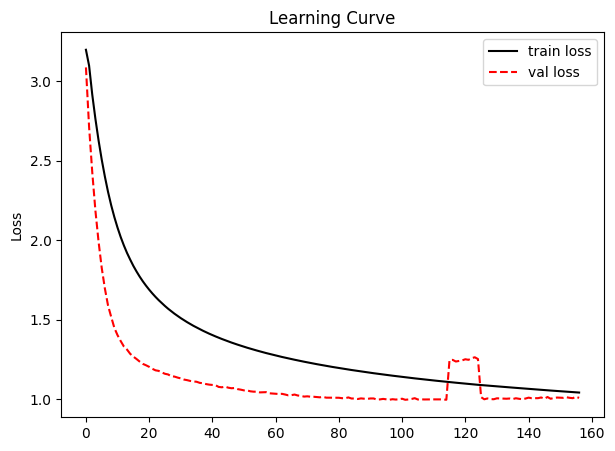

In [24]:
n_hidden=1024
n_layers=2
net = CharRNN(chars, n_hidden, n_layers, drop_prob = 0)
train(net, encoded, epochs=15, lr=0.001, print_every=100)

#### The sudden spike is strange: looks like it starts an overfitting trend (validation error went from roughly 0.99 to 1.01). 

In [26]:
print(sample(net, 2000, prime='The flight', top_k=5))

The flight was delayed. Then, the customer service representative spoke to us was telling me they were going to discost us and she walked away. I had to book all of two extra bagh on our vacation. As sitting at the airport and will never at lease think this is the only responsibility to tell you what the airline has sent one. I have always been denied this review at the airport when they are a lie flying in a ridiculous experience. The contacting from the airline would not offer her and a carry on was to check if an interconnecting flight was allowed to accommodate them, as it was a connecting flight which is too big at this situation and then told escort and looking for a refund of my bank still they say it was necessary in there when we alerted our ticket with an agent in the airport. The plane was delayed by 40 minutes, a car tinted saying that they didn't eat for a cancellation or arrival time. Then we were told we would be gaibing and didn't see the call convenience that they had 

#### Looks like a bigger percentage of the sentences start to make sense. But we can notice some error in word construction ("to discost", "bagh" instead of "bags", "at lease",...). Effects of overfitting?

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15... Step: 100... Loss: 3.1298... Val Loss: 3.0871
Epoch: 1/15... Step: 200... Loss: 3.1031... Val Loss: 3.0894
Epoch: 1/15... Step: 300... Loss: 3.1142... Val Loss: 3.0890
Epoch: 1/15... Step: 400... Loss: 3.0989... Val Loss: 3.0880
Epoch: 1/15... Step: 500... Loss: 3.0801... Val Loss: 3.0871
Epoch: 1/15... Step: 600... Loss: 2.9360... Val Loss: 2.8982
Epoch: 1/15... Step: 700... Loss: 2.6120... Val Loss: 2.6066
Epoch: 1/15... Step: 800... Loss: 2.5201... Val Loss: 2.4213
Epoch: 1/15... Step: 900... Loss: 2.2572... Val Loss: 2.2092
Epoch: 1/15... Step: 1000... Loss: 2.0727... Val Loss: 2.0042


  7%|▋         | 1/15 [52:32<12:15:41, 3152.98s/it]

Epoch: 2/15... Step: 1100... Loss: 1.9023... Val Loss: 1.8247
Epoch: 2/15... Step: 1200... Loss: 1.7777... Val Loss: 1.6773
Epoch: 2/15... Step: 1300... Loss: 1.6076... Val Loss: 1.5679
Epoch: 2/15... Step: 1400... Loss: 1.5594... Val Loss: 1.4897
Epoch: 2/15... Step: 1500... Loss: 1.4855... Val Loss: 1.4327
Epoch: 2/15... Step: 1600... Loss: 1.4422... Val Loss: 1.3882
Epoch: 2/15... Step: 1700... Loss: 1.4453... Val Loss: 1.3561
Epoch: 2/15... Step: 1800... Loss: 1.3828... Val Loss: 1.3271
Epoch: 2/15... Step: 1900... Loss: 1.4032... Val Loss: 1.3036
Epoch: 2/15... Step: 2000... Loss: 1.3076... Val Loss: 1.2836


 13%|█▎        | 2/15 [1:41:57<10:59:04, 3041.89s/it]

Epoch: 3/15... Step: 2100... Loss: 1.3341... Val Loss: 1.2662
Epoch: 3/15... Step: 2200... Loss: 1.3011... Val Loss: 1.2519
Epoch: 3/15... Step: 2300... Loss: 1.3117... Val Loss: 1.2366
Epoch: 3/15... Step: 2400... Loss: 1.2708... Val Loss: 1.2276
Epoch: 3/15... Step: 2500... Loss: 1.3107... Val Loss: 1.2158
Epoch: 3/15... Step: 2600... Loss: 1.2394... Val Loss: 1.2049
Epoch: 3/15... Step: 2700... Loss: 1.2545... Val Loss: 1.1963
Epoch: 3/15... Step: 2800... Loss: 1.2550... Val Loss: 1.1869
Epoch: 3/15... Step: 2900... Loss: 1.2674... Val Loss: 1.1809
Epoch: 3/15... Step: 3000... Loss: 1.1967... Val Loss: 1.1744
Epoch: 3/15... Step: 3100... Loss: 1.2512... Val Loss: 1.1660


 20%|██        | 3/15 [2:33:41<10:14:05, 3070.45s/it]

Epoch: 4/15... Step: 3200... Loss: 1.1714... Val Loss: 1.1606
Epoch: 4/15... Step: 3300... Loss: 1.2170... Val Loss: 1.1537
Epoch: 4/15... Step: 3400... Loss: 1.1690... Val Loss: 1.1491
Epoch: 4/15... Step: 3500... Loss: 1.1699... Val Loss: 1.1413
Epoch: 4/15... Step: 3600... Loss: 1.1832... Val Loss: 1.1385
Epoch: 4/15... Step: 3700... Loss: 1.1510... Val Loss: 1.1322
Epoch: 4/15... Step: 3800... Loss: 1.1966... Val Loss: 1.1281
Epoch: 4/15... Step: 3900... Loss: 1.1585... Val Loss: 1.1228
Epoch: 4/15... Step: 4000... Loss: 1.1280... Val Loss: 1.1183
Epoch: 4/15... Step: 4100... Loss: 1.1204... Val Loss: 1.1149


 27%|██▋       | 4/15 [3:23:06<9:15:17, 3028.84s/it] 

Epoch: 5/15... Step: 4200... Loss: 1.1363... Val Loss: 1.1105
Epoch: 5/15... Step: 4300... Loss: 1.1593... Val Loss: 1.1063
Epoch: 5/15... Step: 4400... Loss: 1.1369... Val Loss: 1.1026
Epoch: 5/15... Step: 4500... Loss: 1.1155... Val Loss: 1.1008
Epoch: 5/15... Step: 4600... Loss: 1.1055... Val Loss: 1.0955
Epoch: 5/15... Step: 4700... Loss: 1.1255... Val Loss: 1.0931
Epoch: 5/15... Step: 4800... Loss: 1.1281... Val Loss: 1.0895
Epoch: 5/15... Step: 4900... Loss: 1.1018... Val Loss: 1.0853
Epoch: 5/15... Step: 5000... Loss: 1.0955... Val Loss: 1.0844
Epoch: 5/15... Step: 5100... Loss: 1.0775... Val Loss: 1.0788
Epoch: 5/15... Step: 5200... Loss: 1.1176... Val Loss: 1.0772


 33%|███▎      | 5/15 [4:14:45<8:29:02, 3054.28s/it]

Epoch: 6/15... Step: 5300... Loss: 1.0678... Val Loss: 1.0737
Epoch: 6/15... Step: 5400... Loss: 1.0770... Val Loss: 1.0694
Epoch: 6/15... Step: 5500... Loss: 1.0975... Val Loss: 1.0692
Epoch: 6/15... Step: 5600... Loss: 1.0484... Val Loss: 1.0655
Epoch: 6/15... Step: 5700... Loss: 1.0819... Val Loss: 1.0633
Epoch: 6/15... Step: 5800... Loss: 1.0928... Val Loss: 1.0600
Epoch: 6/15... Step: 5900... Loss: 1.0922... Val Loss: 1.0585
Epoch: 6/15... Step: 6000... Loss: 1.0658... Val Loss: 1.0570
Epoch: 6/15... Step: 6100... Loss: 1.0422... Val Loss: 1.0531
Epoch: 6/15... Step: 6200... Loss: 1.0599... Val Loss: 1.0522


 40%|████      | 6/15 [5:28:05<8:46:45, 3511.68s/it]

Epoch: 7/15... Step: 6300... Loss: 1.0856... Val Loss: 1.0493
Epoch: 7/15... Step: 6400... Loss: 1.0917... Val Loss: 1.0447
Epoch: 7/15... Step: 6500... Loss: 1.0453... Val Loss: 1.0428
Epoch: 7/15... Step: 6600... Loss: 1.0369... Val Loss: 1.0432
Epoch: 7/15... Step: 6700... Loss: 1.0617... Val Loss: 1.0407
Epoch: 7/15... Step: 6800... Loss: 1.0707... Val Loss: 1.0387
Epoch: 7/15... Step: 6900... Loss: 1.0410... Val Loss: 1.0379
Epoch: 7/15... Step: 7000... Loss: 1.0506... Val Loss: 1.0308
Epoch: 7/15... Step: 7100... Loss: 1.0090... Val Loss: 1.0343
Epoch: 7/15... Step: 7200... Loss: 1.0106... Val Loss: 1.0283
Epoch: 7/15... Step: 7300... Loss: 1.0309... Val Loss: 1.0242


 47%|████▋     | 7/15 [6:23:03<7:38:55, 3441.90s/it]

Epoch: 8/15... Step: 7400... Loss: 1.0316... Val Loss: 1.0225
Epoch: 8/15... Step: 7500... Loss: 1.0247... Val Loss: 1.0198
Epoch: 8/15... Step: 7600... Loss: 1.0260... Val Loss: 1.0195
Epoch: 8/15... Step: 7700... Loss: 1.0141... Val Loss: 1.0170
Epoch: 8/15... Step: 7800... Loss: 0.9903... Val Loss: 1.0157
Epoch: 8/15... Step: 7900... Loss: 1.0298... Val Loss: 1.0151
Epoch: 8/15... Step: 8000... Loss: 1.0212... Val Loss: 1.0149
Epoch: 8/15... Step: 8100... Loss: 1.0286... Val Loss: 1.0111
Epoch: 8/15... Step: 8200... Loss: 1.0176... Val Loss: 1.0095
Epoch: 8/15... Step: 8300... Loss: 1.0208... Val Loss: 1.0082


 53%|█████▎    | 8/15 [7:12:34<6:24:04, 3292.05s/it]

Epoch: 9/15... Step: 8400... Loss: 1.0094... Val Loss: 1.0071
Epoch: 9/15... Step: 8500... Loss: 1.0096... Val Loss: 1.0038
Epoch: 9/15... Step: 8600... Loss: 1.0316... Val Loss: 1.0052
Epoch: 9/15... Step: 8700... Loss: 1.0114... Val Loss: 1.0028
Epoch: 9/15... Step: 8800... Loss: 1.0098... Val Loss: 1.0018
Epoch: 9/15... Step: 8900... Loss: 0.9872... Val Loss: 1.0006
Epoch: 9/15... Step: 9000... Loss: 0.9449... Val Loss: 1.0003
Epoch: 9/15... Step: 9100... Loss: 0.9900... Val Loss: 0.9978
Epoch: 9/15... Step: 9200... Loss: 1.0067... Val Loss: 0.9953
Epoch: 9/15... Step: 9300... Loss: 1.0358... Val Loss: 0.9948
Epoch: 9/15... Step: 9400... Loss: 0.9878... Val Loss: 0.9934


 60%|██████    | 9/15 [8:06:30<5:27:26, 3274.35s/it]

Epoch: 10/15... Step: 9500... Loss: 1.0035... Val Loss: 0.9930
Epoch: 10/15... Step: 9600... Loss: 0.9962... Val Loss: 0.9906
Epoch: 10/15... Step: 9700... Loss: 1.0192... Val Loss: 0.9903
Epoch: 10/15... Step: 9800... Loss: 1.0064... Val Loss: 0.9901
Epoch: 10/15... Step: 9900... Loss: 0.9517... Val Loss: 0.9876
Epoch: 10/15... Step: 10000... Loss: 1.0046... Val Loss: 0.9880
Epoch: 10/15... Step: 10100... Loss: 0.9774... Val Loss: 0.9872
Epoch: 10/15... Step: 10200... Loss: 0.9664... Val Loss: 0.9874
Epoch: 10/15... Step: 10300... Loss: 0.9677... Val Loss: 0.9843
Epoch: 10/15... Step: 10400... Loss: 1.0348... Val Loss: 0.9824


 67%|██████▋   | 10/15 [8:44:26<4:07:10, 2966.01s/it]

Epoch: 11/15... Step: 10500... Loss: 0.9899... Val Loss: 0.9829
Epoch: 11/15... Step: 10600... Loss: 0.9496... Val Loss: 0.9807
Epoch: 11/15... Step: 10700... Loss: 0.9576... Val Loss: 0.9814
Epoch: 11/15... Step: 10800... Loss: 0.9524... Val Loss: 0.9800
Epoch: 11/15... Step: 10900... Loss: 0.9713... Val Loss: 0.9784
Epoch: 11/15... Step: 11000... Loss: 0.9588... Val Loss: 0.9780
Epoch: 11/15... Step: 11100... Loss: 0.9848... Val Loss: 0.9780
Epoch: 11/15... Step: 11200... Loss: 0.9615... Val Loss: 0.9781
Epoch: 11/15... Step: 11300... Loss: 0.9813... Val Loss: 0.9774
Epoch: 11/15... Step: 11400... Loss: 0.9780... Val Loss: 0.9749
Epoch: 11/15... Step: 11500... Loss: 0.9955... Val Loss: 0.9743


 73%|███████▎  | 11/15 [9:18:43<2:59:11, 2687.89s/it]

Epoch: 12/15... Step: 11600... Loss: 0.9784... Val Loss: 0.9744
Epoch: 12/15... Step: 11700... Loss: 1.0008... Val Loss: 0.9729
Epoch: 12/15... Step: 11800... Loss: 0.9657... Val Loss: 0.9715
Epoch: 12/15... Step: 11900... Loss: 0.9822... Val Loss: 0.9724
Epoch: 12/15... Step: 12000... Loss: 0.9422... Val Loss: 0.9719
Epoch: 12/15... Step: 12100... Loss: 0.9497... Val Loss: 0.9694
Epoch: 12/15... Step: 12200... Loss: 0.9587... Val Loss: 0.9707
Epoch: 12/15... Step: 12300... Loss: 0.9540... Val Loss: 0.9688
Epoch: 12/15... Step: 12400... Loss: 0.9473... Val Loss: 0.9675
Epoch: 12/15... Step: 12500... Loss: 0.9801... Val Loss: 0.9687


 80%|████████  | 12/15 [9:51:37<2:03:32, 2470.68s/it]

Epoch: 13/15... Step: 12600... Loss: 0.9449... Val Loss: 0.9695
Epoch: 13/15... Step: 12700... Loss: 0.9478... Val Loss: 0.9671
Epoch: 13/15... Step: 12800... Loss: 0.9319... Val Loss: 0.9651
Epoch: 13/15... Step: 12900... Loss: 0.9590... Val Loss: 0.9646
Epoch: 13/15... Step: 13000... Loss: 0.9624... Val Loss: 0.9648
Epoch: 13/15... Step: 13100... Loss: 0.9433... Val Loss: 0.9644
Epoch: 13/15... Step: 13200... Loss: 0.9797... Val Loss: 0.9647
Epoch: 13/15... Step: 13300... Loss: 0.9012... Val Loss: 0.9626
Epoch: 13/15... Step: 13400... Loss: 0.9226... Val Loss: 0.9626
Epoch: 13/15... Step: 13500... Loss: 0.9514... Val Loss: 0.9621
Epoch: 13/15... Step: 13600... Loss: 0.9571... Val Loss: 0.9640


 87%|████████▋ | 13/15 [10:25:58<1:18:13, 2346.69s/it]

Epoch: 14/15... Step: 13700... Loss: 0.9451... Val Loss: 0.9633
Epoch: 14/15... Step: 13800... Loss: 0.9444... Val Loss: 0.9606
Epoch: 14/15... Step: 13900... Loss: 0.9453... Val Loss: 0.9613
Epoch: 14/15... Step: 14000... Loss: 0.9671... Val Loss: 0.9628
Epoch: 14/15... Step: 14100... Loss: 0.9286... Val Loss: 0.9606
Epoch: 14/15... Step: 14200... Loss: 0.9069... Val Loss: 0.9593
Epoch: 14/15... Step: 14300... Loss: 0.9337... Val Loss: 0.9588
Epoch: 14/15... Step: 14400... Loss: 0.9224... Val Loss: 0.9613
Epoch: 14/15... Step: 14500... Loss: 0.9381... Val Loss: 0.9594
Epoch: 14/15... Step: 14600... Loss: 0.9243... Val Loss: 0.9581


 93%|█████████▎| 14/15 [10:59:27<37:24, 2244.56s/it]  

Epoch: 15/15... Step: 14700... Loss: 0.9169... Val Loss: 0.9570
Epoch: 15/15... Step: 14800... Loss: 0.9138... Val Loss: 0.9575
Epoch: 15/15... Step: 14900... Loss: 0.9250... Val Loss: 0.9556
Epoch: 15/15... Step: 15000... Loss: 0.8965... Val Loss: 0.9563
Epoch: 15/15... Step: 15100... Loss: 0.9219... Val Loss: 0.9582
Epoch: 15/15... Step: 15200... Loss: 0.9169... Val Loss: 0.9589
Epoch: 15/15... Step: 15300... Loss: 0.9300... Val Loss: 0.9558
Epoch: 15/15... Step: 15400... Loss: 0.9072... Val Loss: 0.9574
Epoch: 15/15... Step: 15500... Loss: 0.9106... Val Loss: 0.9538
Epoch: 15/15... Step: 15600... Loss: 0.9001... Val Loss: 0.9537
Epoch: 15/15... Step: 15700... Loss: 0.9032... Val Loss: 0.9556


100%|██████████| 15/15 [11:34:22<00:00, 2777.52s/it]


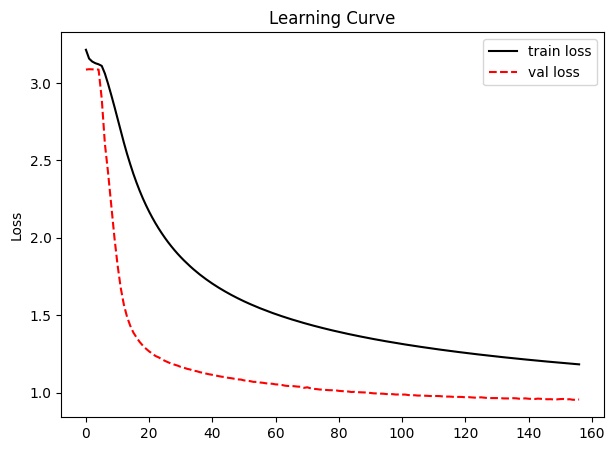

In [24]:
n_hidden=1024
n_layers=3
net = CharRNN(chars, n_hidden, n_layers, drop_prob = 0.2)
train(net, encoded, epochs=15, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=100)

In [31]:
print(sample(net, 2000, prime='The flight', top_k=5))

The flight was supposed to be an emergency exit row before departure. An overnight flight from Saogano to Bonaire had no choice of drinks. It is a lot of serving a free seat, which are not easy and not served out of the airplane with a lot to be served for a bus ticket. I would like to fly them again.
  I wasn't able to stay two delays or two finally booked in the next flight because of an intercontinental problem. So we called and asked who had already been trying to get to the airport which was not the airline for me to buy another ticket and they told me that it was disconnected but they were still waiting for me to sit together in my original flight. They sent them two months this week before I call the flight attendant faces on an earlier flight but it was not enough! They do not ruin the phone the problem and they could not speak with any other option and was told the pandemic claim they went on time for the next morning flight back through Seaborne. At the check-in counter the f

Words look all correct: that reinforces the "overfitting" theory of the previous model. But sentence construction looks a little bit worse, even though "An overnight flight from Saogano to Bonaire had no choice of drinks." is a valid one.

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1/3... Step: 100... Loss: 3.1243... Val Loss: 3.0866
Epoch: 1/3... Step: 200... Loss: 3.1027... Val Loss: 3.0876
Epoch: 1/3... Step: 300... Loss: 3.1174... Val Loss: 3.0890
Epoch: 1/3... Step: 400... Loss: 3.0988... Val Loss: 3.0871
Epoch: 1/3... Step: 500... Loss: 3.0839... Val Loss: 3.0874
Epoch: 1/3... Step: 600... Loss: 3.1046... Val Loss: 3.0880
Epoch: 1/3... Step: 700... Loss: 3.0835... Val Loss: 3.0872
Epoch: 1/3... Step: 800... Loss: 3.1177... Val Loss: 3.0870
Epoch: 1/3... Step: 900... Loss: 3.0947... Val Loss: 3.0886
Epoch: 1/3... Step: 1000... Loss: 3.0827... Val Loss: 3.0877


 33%|███▎      | 1/3 [17:15<34:30, 1035.41s/it]

Epoch: 2/3... Step: 1100... Loss: 3.0869... Val Loss: 3.0866
Epoch: 2/3... Step: 1200... Loss: 3.0939... Val Loss: 3.0875
Epoch: 2/3... Step: 1300... Loss: 3.0780... Val Loss: 3.0862
Epoch: 2/3... Step: 1400... Loss: 3.0867... Val Loss: 3.0863
Epoch: 2/3... Step: 1500... Loss: 3.0691... Val Loss: 3.0871
Epoch: 2/3... Step: 1600... Loss: 3.0947... Val Loss: 3.0867
Epoch: 2/3... Step: 1700... Loss: 3.0807... Val Loss: 3.0864
Epoch: 2/3... Step: 1800... Loss: 3.0885... Val Loss: 3.0868
Epoch: 2/3... Step: 1900... Loss: 3.0843... Val Loss: 3.0865
Epoch: 2/3... Step: 2000... Loss: 3.0877... Val Loss: 3.0873


 67%|██████▋   | 2/3 [34:30<17:15, 1035.12s/it]

Epoch: 3/3... Step: 2100... Loss: 3.0917... Val Loss: 3.0864
Epoch: 3/3... Step: 2200... Loss: 3.0848... Val Loss: 3.0860
Epoch: 3/3... Step: 2300... Loss: 3.0968... Val Loss: 3.0867
Epoch: 3/3... Step: 2400... Loss: 3.1021... Val Loss: 3.0868
Epoch: 3/3... Step: 2500... Loss: 3.1130... Val Loss: 3.0865
Epoch: 3/3... Step: 2600... Loss: 3.0811... Val Loss: 3.0863
Epoch: 3/3... Step: 2700... Loss: 3.0914... Val Loss: 3.0867
Epoch: 3/3... Step: 2800... Loss: 3.1070... Val Loss: 3.0860
Epoch: 3/3... Step: 2900... Loss: 3.1216... Val Loss: 3.0864
Epoch: 3/3... Step: 3000... Loss: 3.0874... Val Loss: 3.0869
Epoch: 3/3... Step: 3100... Loss: 3.1073... Val Loss: 3.0870


100%|██████████| 3/3 [52:36<00:00, 1052.05s/it]


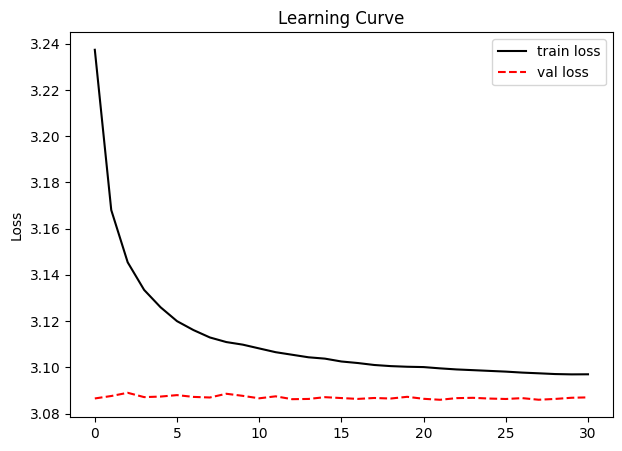

In [17]:
net = CharRNN(chars, n_hidden = 512, n_layers = 4, drop_prob = 0.1)
train(net, encoded, epochs=3, lr=0.001, print_every=100)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1/3... Step: 100... Loss: 3.1312... Val Loss: 3.0869
Epoch: 1/3... Step: 200... Loss: 3.1043... Val Loss: 3.0892
Epoch: 1/3... Step: 300... Loss: 3.1156... Val Loss: 3.0891
Epoch: 1/3... Step: 400... Loss: 3.1003... Val Loss: 3.0877
Epoch: 1/3... Step: 500... Loss: 3.0817... Val Loss: 3.0873
Epoch: 1/3... Step: 600... Loss: 3.1018... Val Loss: 3.0878
Epoch: 1/3... Step: 700... Loss: 3.0829... Val Loss: 3.0869
Epoch: 1/3... Step: 800... Loss: 3.1182... Val Loss: 3.0875
Epoch: 1/3... Step: 900... Loss: 3.0927... Val Loss: 3.0885
Epoch: 1/3... Step: 1000... Loss: 3.0815... Val Loss: 3.0875


 33%|███▎      | 1/3 [46:13<1:32:27, 2773.51s/it]

Epoch: 2/3... Step: 1100... Loss: 3.0867... Val Loss: 3.0866
Epoch: 2/3... Step: 1200... Loss: 3.0944... Val Loss: 3.0877
Epoch: 2/3... Step: 1300... Loss: 3.0766... Val Loss: 3.0863
Epoch: 2/3... Step: 1400... Loss: 3.0862... Val Loss: 3.0856
Epoch: 2/3... Step: 1500... Loss: 3.0696... Val Loss: 3.0865
Epoch: 2/3... Step: 1600... Loss: 3.0946... Val Loss: 3.0866
Epoch: 2/3... Step: 1700... Loss: 3.0814... Val Loss: 3.0858
Epoch: 2/3... Step: 1800... Loss: 3.0886... Val Loss: 3.0863
Epoch: 2/3... Step: 1900... Loss: 3.0834... Val Loss: 3.0860
Epoch: 2/3... Step: 2000... Loss: 3.0873... Val Loss: 3.0863


 67%|██████▋   | 2/3 [1:33:18<46:43, 2803.96s/it]

Epoch: 3/3... Step: 2100... Loss: 3.0932... Val Loss: 3.0867
Epoch: 3/3... Step: 2200... Loss: 3.0855... Val Loss: 3.0860
Epoch: 3/3... Step: 2300... Loss: 3.0968... Val Loss: 3.0860
Epoch: 3/3... Step: 2400... Loss: 3.1020... Val Loss: 3.0868
Epoch: 3/3... Step: 2500... Loss: 3.1136... Val Loss: 3.0864
Epoch: 3/3... Step: 2600... Loss: 3.0820... Val Loss: 3.0862
Epoch: 3/3... Step: 2700... Loss: 3.0913... Val Loss: 3.0864
Epoch: 3/3... Step: 2800... Loss: 3.1070... Val Loss: 3.0854
Epoch: 3/3... Step: 2900... Loss: 2.6734... Val Loss: 2.5709
Epoch: 3/3... Step: 3000... Loss: 2.2258... Val Loss: 2.1864
Epoch: 3/3... Step: 3100... Loss: 2.0288... Val Loss: 1.8934


100%|██████████| 3/3 [2:23:31<00:00, 2870.43s/it]


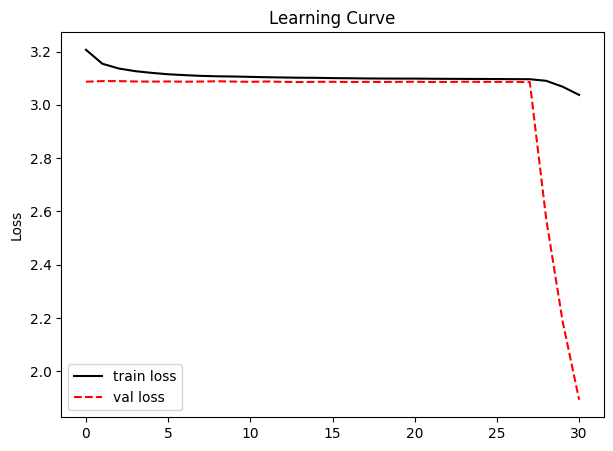

In [18]:
net = CharRNN(chars, n_hidden = 1024, n_layers = 4, drop_prob = 0.2)
train(net, encoded, epochs=3, lr=0.001, print_every=100)

In [22]:
net = load("./preTrained/2_512_0.net")
print(sample(net, 2000, top_k=5, prime="The flight"))

The flight was disgusting choices. Totally task as they would be checked in our bag on them as there was no infant another cabin crew asked to spot back. Was on another two flights from Belta. The airline she traveller there was on the flight attendants weren’t that they wouldn't even another ticket would be allowed boarding took off and a good flights are not a seat in but that’s a few handling to the part from the airport it’s not a cup of seats for all the flight from this airline in the airport and at a cabin crowd and well was the following day of a bridge, this flight went the finally at a check in and was clean. The problem and thinker company of the planes are such a later they checking a seat attendant. They can’t check my chinger than this flight from Lakarto and was travelling and the service is on hit my last regularly so I cannot having an overnight attendants took over.
  The airport the plane was still. The service on both of one warmed and then will never been a little 

increase batch?

Final considerations

Should be improved by constructing a proper grid search, with early stopping techniques, also varying the other parameters, like batch size, learning rate etc. Also implementing checkpointing at every epoch. The problem is the really slow training: training for a bigger number of epochs (especially on the bigger models) would have probably yielded more diverse results and would have allowed us to really capture the behavioural differences.
Apparently, there was no need for dropout, at least for the amount of training that was done: validation error never rose. Anyway I still "instinctively" added it on more parametrised models (again, of course a proper grid search would be more appropriate).

Strange behaviours during training (validation spike and plateau in the last, more complex models -> implementation errors / numerical instability (gradient explosion)?)